In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi = False

## either import the functions stored in agc.py or install from PyPI
from agc import * 


# Random example

- We use this dataset throughout
- **N = 20,000** with 5% positive labels
- Bimodal distribution for the positive case

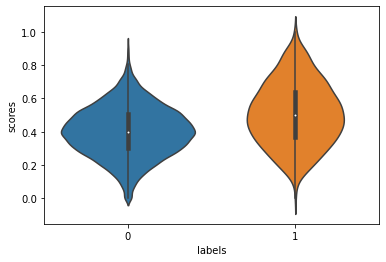

In [3]:
## labels
N = 20000
N_pos = 1000
labels = np.concatenate((np.repeat(1,N_pos),np.repeat(0,N-N_pos)))

## scores
scores = np.concatenate((np.random.normal(.75,.1,N_pos//5),np.random.normal(.45,.15,N_pos-N_pos//5),
                         np.random.normal(.4,.15,N-N_pos)))

## clumping
scores = [min(1,i) for i in scores]
scores = [max(0,i) for i in scores]

## plot
D = pd.DataFrame()
D['labels']=labels
D['scores']=scores
ax = sns.violinplot(x="labels", y="scores", data=D)

# ROC and AUC

- define TP: number of true positives, FP: false positives, TN: true negatives, FN: false negatives
- TruePositiveRate: TPR = TP/(TP+FN)
- FalsePositiveRate: FPR = FP/(FP+TN)
- ROC curve: plot TPR vs FPR for all possible thresholds
- AUC is the area under the ROC curve via trapezoidal rule
- For random ordering, expected AUC is R(AUC) = 0.5.
- Maximum value for AUC is: M(AUC)=1
- interpretation: AUC = Pr(score of random positive case > score of random negative case)
- Thus, one can easily approximate AUC even for huge datasets by sampling (with replacement) from positive cases, sampling (with replacement) negative cases and compare the samples.

We also define the **normalized AUC** as **AUC' = (AUC - R(AUC))/(M(AUC) - R(AUC)) = 2*AUC - 1**
so AUC' is the proportion of potential improvement over random that we achieved; this can be negative is we do worse than random.


In [4]:
## AUC
fpr, tpr, thresholds = roc_curve(np.array(labels), np.array(scores), pos_label=1)
AUC = roc_auc_score(np.array(labels), np.array(scores))
print('AUC=',AUC,'AUC\'=',(AUC-.5)/.5)

AUC= 0.6614178947368421 AUC'= 0.3228357894736842


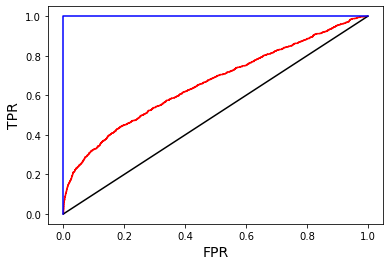

In [5]:
## plot ROC
## AUC = "area under red curve"
## AUC'= ("area under red curve"-"area under black curve")/("area under blue curve"-"area under black curve")
plt.plot(fpr,tpr,color='red')
plt.plot([0,1],[0,1],color='black')
plt.plot([0,0,1],[0,1,1],color='blue')
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14);

# Precision-recall curve

* recall = TP/(TP+FN)
* precision = TP/(TP+FP)
* we plot precision vs recall; result can be summarized via area under the curve using the trapeziodal rule, or the (similar) average precision (AP)
* Maximum value is 1, expected value under random classifier is the proportion of positive label points


In [6]:
## Precision-recall
precision, recall, _ = precision_recall_curve(np.array(labels), np.array(scores), pos_label=1)
print('Area under curve:',auc(recall, precision))
print('Average precision:',average_precision_score(np.array(labels), np.array(scores), pos_label=1))

Area under curve: 0.1674879754040502
Average precision: 0.16796861453729195


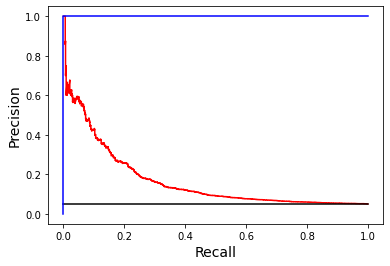

In [7]:
## plot PR curve
plt.plot(recall,precision,color='red')
plt.xlabel('Recall',fontsize=14)
plt.ylabel('Precision',fontsize=14);
plt.plot([0,1],[N_pos/N,N_pos/N],color='black')
plt.plot([0,0,1],[0,1,1],color='blue');


# Gain curves

For AUC or AP, we consider the entire curve. In practice, we may be very restricted in terms of the number of points we can look at, so we want as many positive cases to score high, say in the **top-k** or the **top (100*q)%**.

We can look at the precision for the top-k, but this neglects the ordering. One alternative is to look at **gain** curves. Let N be the total number of data points. We plot a gain curve by plotting: 

- for the x-axis: (TP+FP)/N, the proportion of points at or above the threshold, and
- for the y-axis: TPR.

Thus, is is simple to **truncate** a gain curve by looking only at the **top (100*q)%** scoring points as we show below.


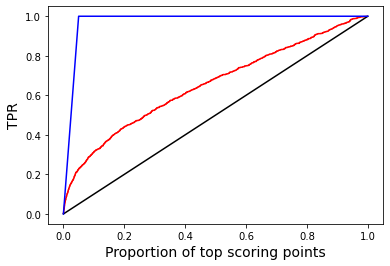

In [8]:
## plot gain curve as well as max and (expected) random curves
top, tpr, _ = gain_curve(y_true=labels, y_score=scores, pos_label=1, truncate=1)
plt.plot(top,tpr,'red')
plt.plot([0,1],[0,1],color='black') ## random
r = N_pos/N ## proportion of positives overall
plt.plot([0,r,1],[0,1,1],color='blue'); ## max
plt.xlabel('Proportion of top scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

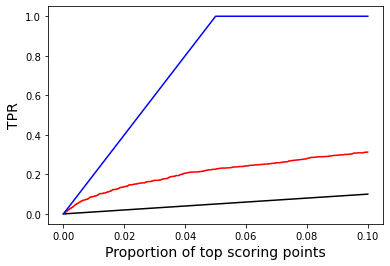

In [9]:
## partial gain curve - truncate at 10%
trunc = .1
top, tpr, _ = gain_curve(y_true=labels, y_score=scores, pos_label=1, truncate=trunc)
plt.plot(top,tpr,'red')
plt.plot([0,trunc],[0,trunc],color='black') ## random
r = N_pos/N ## proportion of positives overall
if r <= trunc:
    plt.plot([0,r,trunc],[0,1,1],color='blue') ## max
else:
    plt.plot([0,trunc],[0,N*trunc/N_pos],color='blue');
plt.xlabel('Proportion of top scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

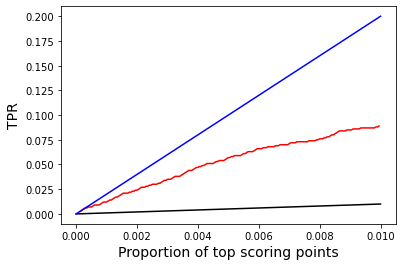

In [10]:
## partial gain curve - truncate at 1%
trunc = .01
top, tpr, _ = gain_curve(y_true=labels, y_score=scores, pos_label=1, truncate=trunc)
plt.plot(top,tpr,'red')
plt.plot([0,trunc],[0,trunc],color='black') ## random
r = N_pos/N ## proportion of positives overall
if r <= trunc:
    plt.plot([0,r,trunc],[0,1,1],color='blue') ## max
else:
    plt.plot([0,trunc],[0,N*trunc/N_pos],color='blue');
plt.xlabel('Proportion of top scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

# AGC - area under the gain curve

Everything so far is well known. We now introduce our new results.

Consider the normalized area under the gain curve

**AGC'(q) = (AGC(q) - R(AGC(q)))/(M(AGC(q)) - R(AGC(q)))**

with the option of **truncating** the curve to the **top-(100q)%** scoring points.

We wrote two new functions to compute AGC':
- AGC where parameter truncate = **q**
    - we can also pass an integer q>1 in which case we consider the top-q points
- AGC_sample: approximation of AGC, useful for huge graphs, with two extra parameters: 
    - sample (proportion of points to sample)
    - quantiles (number of quantiles to use for binning)

**Proposition** (proof in our paper): AGC'(1) = AUC', i.e. when no truncation is done.

Finaly, unlike AUC, the maximum value M(AGC)<1, so for the un-normalized area, we consider AGC/M(AGC) so that a perfect ordering yields a value of 1.


## Truncated gain function and version with sampling

In [11]:
print("AGC':",agc_score(y_true=labels, y_score=scores, pos_label=1),
'approx_1:',agc_approximate(y_true=labels, y_score=scores, sample=1, quantiles=200, pos_label=1),
'approx_2:',agc_approximate(y_true=labels, y_score=scores, sample=.5, quantiles=100, pos_label=1))


AGC': 0.3228357894736842 approx_1: 0.32271578947368423 approx_2: 0.3176929776227903


In [12]:
## Recall tht AGC' = AUC' when no truncation is done, let's check
(AUC-.5)/.5

0.3228357894736842

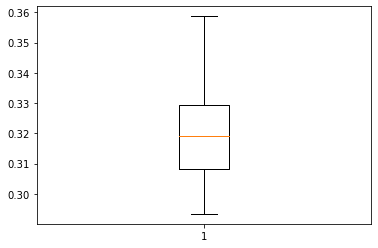

In [13]:
## looking at distribution for several approximations
g = []
for i in range(30):
    g.append(agc_approximate(y_true=labels, y_score=scores, sample=.5, quantiles=100, pos_label=1))
plt.boxplot(g,showfliers=False);

In [14]:
## AGC with truncation to top 10% and approximations
print("AGC':",agc_score(y_true=labels, y_score=scores, pos_label=1, truncate=.1),
'approx_1:',agc_approximate(y_true=labels, y_score=scores, sample=1, quantiles=200, pos_label=1, truncate=.1),
'approx_2:',agc_approximate(y_true=labels, y_score=scores, sample=.5, quantiles=100, pos_label=1, truncate=.1))


AGC': 0.22427392857142858 approx_1: 0.22423928571428572 approx_2: 0.22034626040718255


In [15]:
## AGC with truncation to top 2000 and approximations
print("AGC':",agc_score(y_true=labels, y_score=scores, pos_label=1, truncate=2000),
'approx_1:',agc_approximate(y_true=labels, y_score=scores, sample=1, quantiles=200, pos_label=1, truncate=2000),
'approx_2:',agc_approximate(y_true=labels, y_score=scores, sample=.5, quantiles=100, pos_label=1, truncate=2000))


AGC': 0.22427392857142858 approx_1: 0.22423928571428572 approx_2: 0.2299443736095118


In [16]:
## AGC with truncation to top 1% (dataset too small to sample here)
print("AGC':",agc_score(y_true=labels, y_score=scores, pos_label=1, truncate=.01))


AGC': 0.49307894736842106


In [17]:
## AGC with truncation to top 200 (dataset too small to sample here)
print("AGC':",agc_score(y_true=labels, y_score=scores, pos_label=1, truncate=200))


AGC': 0.49307894736842106


## Weighted dataset

- we add random weights to all datapoints for testing
- default (unweighted) correponds to all weights == 1
- we wrote a function to compute AUC with weights, as this is not an option in sklearn

In [18]:
## generate random weights 
W = 1+9*np.random.exponential(5,size=len(labels))


In [19]:
## compute weighted AUC
AUC = roc_auc_score(np.array(labels), np.array(scores), sample_weight=np.array(W))
print('AUC=',AUC,'AUC\'=',(AUC-.5)/.5)

AUC= 0.6609611732426447 AUC'= 0.3219223464852894


### Sampling approximation to AUC

- AUC = Pr(score for weighted sampled positive point > score for weighted sampled negative point)

In [20]:
## sample size
ss = 2000
## recall - first N_pos points are positive
w_pos = W[:N_pos]/np.sum(W[:N_pos])
w_neg = W[N_pos:]/np.sum(W[N_pos:])
s_pos = [scores[i] for i in np.random.choice(N_pos,size=ss,replace=True,p=w_pos)]
s_neg = [scores[i] for i in N_pos+np.random.choice(N-N_pos,size=ss,replace=True,p=w_neg)]
print('AUC approximation:',sum(np.array(s_pos)>np.array(s_neg))/ss)

AUC approximation: 0.667


### AGC with weights

In [21]:
## weighted AGC
print('AGC = ',agc_score(labels, scores, sample_weight=W, normalized=False))
## weighted AGC' (this = AUC')
print("AGC'= ",agc_score(labels, scores, sample_weight=W, normalized=True))


AGC =  0.6698490492335465
AGC'=  0.3219223464852859


In [22]:
## weighted AND truncated AGC'
print("AGC'= ",agc_score(labels, scores, sample_weight=W, truncate=1000))

## Approximation for AGC'
print("AGC'(approximation):",agc_approximate(labels, scores, sample_weight=W, truncate=1000, sample=.5))


AGC'=  0.25926356945267576
AGC'(approximation): 0.2854720696250302


## Timings - AGC vs sampling

We look at the impact of sample size on the speed and accuracy.

We also look at the number of quantiles, which has much less impact, unless we 
ask for a very large number. The issue there is with the np.quantile() function, 
which can get very slow with thousands of quantiles. We got even slower results with the pandas version.
One way to speed up a little is to use the option interpolation='nearest' instead of the default (linear).
We added this as an option in the function call.

However, we found that such a large number of quantiles is not necessary in the tests we ran.


In [23]:
## first we vary the sample size
import time
REP = 30
start = time.time()
for i in range(REP):
    agc_score(labels, scores)
end = time.time()
T = end-start
A = agc_score(labels, scores)

t = []
a = []
S = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
for s in S:
    x = 0
    start = time.time()
    for i in range(REP):
        x += np.abs(agc_approximate(labels, scores, sample=s, quantiles=100)-A)/A
    end = time.time()
    t.append( 100*(end - start)/T )
    a.append(100*x/REP)


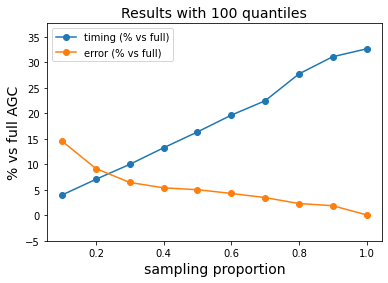

In [24]:
plt.plot(S,t,'o-',label='timing (% vs full)' )
plt.plot(S,a,'o-',label='error (% vs full)')
M = max(a+t)+5
plt.ylim((-5,M))
plt.ylabel('% vs full AGC',fontsize=14)
plt.xlabel('sampling proportion',fontsize=14)
plt.title('Results with 100 quantiles',fontsize=14)
plt.legend();

In [25]:
## now vary number of quantiles, sampling 50%
REP = 30
start = time.time()
for i in range(REP):
    agc_score(labels, scores)
end = time.time()
T = end-start
A = agc_score(labels, scores)

t = []
a = []
Q = np.arange(5,301,20)
for q in Q:
    x = 0
    start = time.time()
    for i in range(REP):
        x += np.abs(agc_approximate(labels, scores, sample=.5, quantiles=q)-A)/A
    end = time.time()
    t.append( 100*(end - start)/T )
    a.append( 100*x/REP )


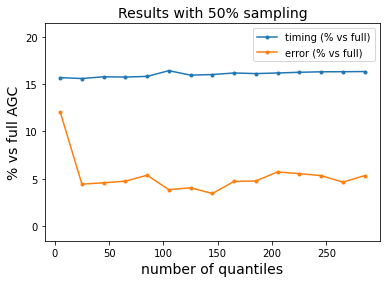

In [26]:
plt.plot(Q,t,'.-',label='timing (% vs full)' )
plt.plot(Q,a,'.-',label='error (% vs full)')
M = max(a+t)+5
m = min(a+t)-5
plt.ylim((m,M))
plt.ylabel('% vs full AGC',fontsize=14)
plt.xlabel('number of quantiles',fontsize=14)
plt.title('Results with 50% sampling',fontsize=14)
plt.legend();